Current: (52.13349293552722, 4.660748132913985), Parent: (52.13348496893562, 4.660748132913985)
Current: (52.13353486901042, 4.660677751033938), Parent: (52.13353886901042, 4.660677751033938)
Current: (52.13353090231882, 4.660785561434166), Parent: (52.13353090231882, 4.660775561434166)
Current: (52.13347496893562, 4.660758804362073), Parent: (52.13348496893562, 4.660758804362073)
Current: (52.13348893562722, 4.660667751104765), Parent: (52.13348893562722, 4.660687751104765)


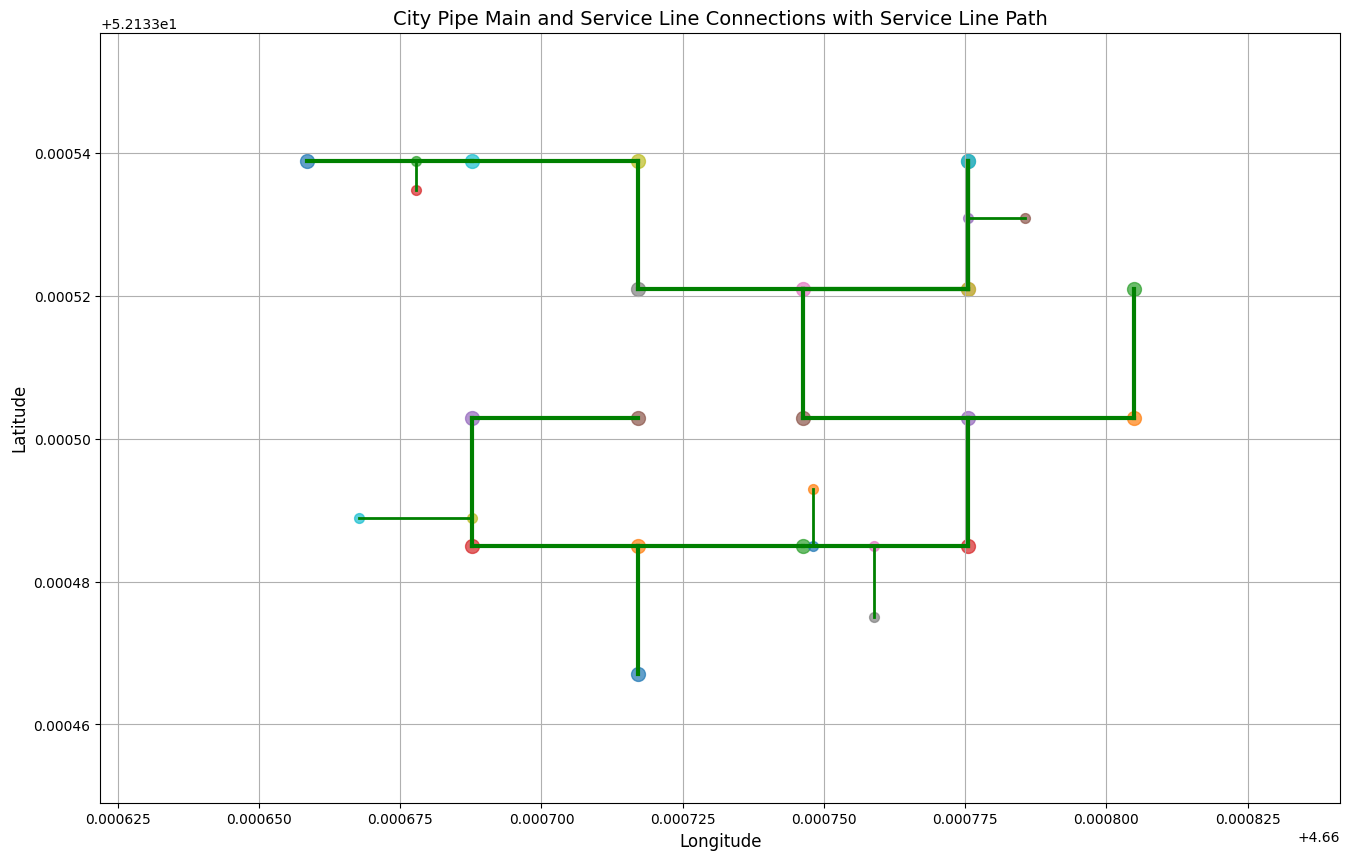

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [168]:

# Load the dataset
file_path_main = 'City_Pipe_Main.csv'  # Replace with the actual file path
city_pipe_main = pd.read_csv(file_path_main)

file_path_service = 'Service_Line_Table.csv'
service_line_table = pd.read_csv(file_path_service)

file_path_corrosion = 'Corrosion.csv'
Corrosion = pd.read_csv(file_path_corrosion)

file_path_house = 'House_Information.csv'
house_information = pd.read_csv(file_path_house)

file_path_pipe_information = 'Pipe_Information.csv'
pipe_information = pd.read_csv(file_path_pipe_information)

file_path_state_of_water = 'State_of_Water.csv'
state_of_water = pd.read_csv(file_path_state_of_water)

# Filter rows with valid coordinates in both datasets
city_pipe_main_valid = city_pipe_main.dropna(subset=['Latitude', 'Longitude'])
service_line_table_valid = service_line_table.dropna(subset=['Latitude', 'Longitude'])

In [170]:
# Define the ranges for normalization
def normalize(value, min_val, max_val):
    return (value - min_val) / (max_val - min_val)

# Initialize variables
corrosion_results = []

# Iterate through the corrosion data to compute the rate and level for each SegmentID
for index, row in Corrosion.iterrows():
    segment_id = row['SegmentID']

    # Merge data from other tables for the current SegmentID
    pipe_data = pipe_information[pipe_information['SegmentID'] == segment_id].iloc[0]
    water_data = state_of_water[state_of_water['SegmentID'] == segment_id].iloc[0]
    
    diameter = pipe_data['Diameter (cm)']
    soil = pipe_data['Soil']
    ph_value = abs(water_data['PH-Value'])
    psi_level = abs(water_data['PSI Level'])
    water_temp = abs(water_data['Water Temperature'])
    
    # Set values based on Diameter (cm)
    if diameter == 30.48:
        mP, mPdev, F, mF, mFdev, fMax = 100, 100, 4700, 4700, 4700, 5405
    elif diameter == 4.1:
        mP, mPdev, F, mF, mFdev, fMax = 45, 85, 36.3, 36.3, 36.3, 41.75
    elif diameter == 3.5:
        mP, mPdev, F, mF, mFdev, fMax = 43, 87, 31, 31, 31, 35.7
    elif diameter == 2.7:
        mP, mPdev, F, mF, mFdev, fMax = 40, 90, 23.9, 23.9, 23.9, 27.49
    else:
        continue 
    
    ranges = {
        "A": (0, 14), "P": (0, 130), "mP": (0, mP), "mPdev": (0, mPdev),
        "T": (5, 15), "X": (2.7, 30.48), "F": (0, fMax), "mF": (0, mF),
        "mFdev": (0, mFdev), "S": (0, 1)
    }
    A = normalize(ph_value, *ranges["A"])
    P = normalize(psi_level, *ranges["P"])
    T = normalize(water_temp, *ranges["T"])
    X = normalize(diameter, *ranges["X"])
    F = normalize(F, *ranges["F"])
    mF = normalize(mF, *ranges["mF"])
    mFdev = normalize(mFdev, *ranges["mFdev"])
    S = 0.7 if soil == "Clay" else 0.4  # Set soil factor
    S = normalize(S, *ranges["S"])
    I = 0.5  # Constant value
    
    # Calculate corrosion rate
    Y = 7
    term1 = 0.16 * (0.3 + (A * (1 + 0.1333)))
    term2 = 0.08 * (0.3 + (abs((P - mP)) * (1 + (1 / mPdev))))
    term3 = 0.16 * (T * (1 + 0.1))
    term4 = 0.08 * (X * (1 + 0.05))
    term5 = 0.16 * (0.3 + (abs((F - mF)) * (1 + (1 / mFdev))))
    term6 = 0.04 * (S * (1 + 0.1))
    term8 = 0.16 * (I * (1 + 0.1))

    corrosion_rate = 100 - (Y * (term1 + term2 + term3 + term4 + term5 + term6 + term8))
    
    # Determine corrosion level
    if 80 <= corrosion_rate <= 100:
        corrosion_level = 1
    elif 60 <= corrosion_rate < 80:
        corrosion_level = 2
    elif 40 <= corrosion_rate < 60:
        corrosion_level = 3
    elif 20 <= corrosion_rate < 40:
        corrosion_level = 4
    elif 0 <= corrosion_rate < 20:
        corrosion_level = 5
    elif corrosion_rate > 100:
        corrosion_level = "Pipe Healed???"
    else:
        corrosion_level = "Pipe corroded."
    
    # Store results
    corrosion_results.append({
        "SegmentID": segment_id,
        "CorrosionRate": corrosion_rate,
        "CorrosionLevel": corrosion_level
    })

corrosion_results_df = pd.DataFrame(corrosion_results)

# updating the column value/data 
#Corrosion['CorrosionLevel'] = corrosion_results_df['CorrosionLevel'].update() 
#Corrosion['CorrosionRate'] = corrosion_results_df['CorrosionRate'] 

# writing into the file 
Corrosion.to_csv("Corrosion.csv", index=True) 

# Create a DataFrame for the results
corrosion_results_df.head(100)

,SegmentID,CorrosionRate,CorrosionLevel
0,57a63f0e-7c18-487b-99d1-5be36bdaf0a5,71.458995,2
1,57954d55-957a-4144-bce1-b582417f7bd3,39.985618,4
2,9be18c15-ee70-4de6-999b-b4d6f487dd9c,72.603748,2
3,8317d426-99fb-4175-9d9c-7b2c015d5762,40.071671,3
4,381ba406-9841-4c7e-85d7-59180f19b14a,71.477127,2
5,b38c419d-0f19-4975-8d7a-d3ff8a77ecbd,40.106201,3
6,e119faae-ae74-4da6-9e26-8c826a383c58,74.193601,2
7,a8414705-99ee-4986-b13d-16a8a7b302ab,40.137856,3
8,70f14523-2812-475a-b7fd-a007d034faa8,72.563856,2
9,e40eab09-15ae-4676-8833-7b61a8a4d3cf,40.077188,3


Current: (52.13349293552722, 4.660748132913985), Parent: (52.13348496893562, 4.660748132913985)
Current: (52.13353486901042, 4.660677751033938), Parent: (52.13353886901042, 4.660677751033938)
Current: (52.13353090231882, 4.660785561434166), Parent: (52.13353090231882, 4.660775561434166)
Current: (52.13347496893562, 4.660758804362073), Parent: (52.13348496893562, 4.660758804362073)
Current: (52.13348893562722, 4.660667751104765), Parent: (52.13348893562722, 4.660687751104765)


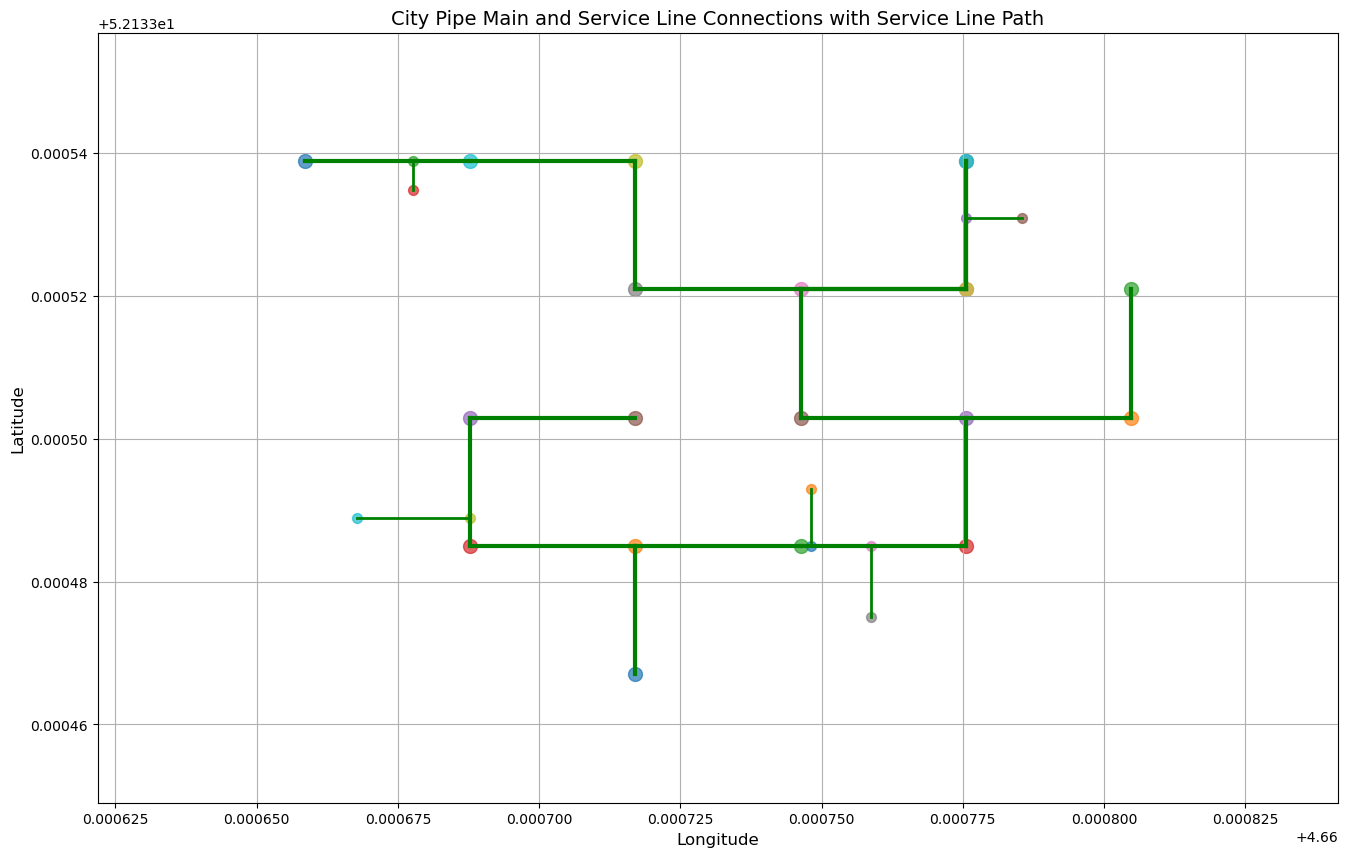

In [ ]:


# Generate unique color mappings for directions from both datasets
all_directions = pd.concat([city_pipe_main_valid['Direction'], service_line_table_valid['Direction']]).unique()
direction_colors = {direction: plt.cm.tab20(i) for i, direction in enumerate(all_directions)}

# Process edges and positions for City Pipe Main
city_edges = []
city_positions = {}

for _, row in city_pipe_main_valid.iterrows():
    city_positions[row['SegmentID']] = (row['Longitude'], row['Latitude'])
    if pd.notna(row['Parent Pipe']):
        parent_row = city_pipe_main_valid[city_pipe_main_valid['SegmentID'] == row['Parent Pipe']]
        if not parent_row.empty:
            parent_lat, parent_lon = parent_row.iloc[0]['Latitude'], parent_row.iloc[0]['Longitude']
            color = direction_colors.get(row['Direction'], 'black')
            city_edges.append(((parent_lon, parent_lat), (row['Longitude'], row['Latitude']), color))

# Process edges and positions for Service Line Table
service_edges = []
service_positions = {}

for _, row in service_line_table_valid.iterrows():
    service_positions[row['SegmentID']] = (row['Longitude'], row['Latitude'])
    # Assume connection through ConnectionID; treat it similar to Parent Pipe
    if pd.notna(row['ConnectionID']):
        connection_row = service_line_table_valid[service_line_table_valid['SegmentID'] == row['ConnectionID']]
        if not connection_row.empty:
            connection_lat, connection_lon = connection_row.iloc[0]['Latitude'], connection_row.iloc[0]['Longitude']
            color = direction_colors.get(row['Direction'], 'gray')  # Default to gray if no direction color found
            service_edges.append(((connection_lon, connection_lat), (row['Longitude'], row['Latitude']), color))

# Calculate the center and zoom based on the combined data
combined_latitudes = pd.concat([city_pipe_main_valid['Latitude'], service_line_table_valid['Latitude']])
combined_longitudes = pd.concat([city_pipe_main_valid['Longitude'], service_line_table_valid['Longitude']])

center_lon = (combined_longitudes.max() + combined_longitudes.min()) / 2
center_lat = (combined_latitudes.max() + combined_latitudes.min()) / 2
lon_range = combined_longitudes.max() - combined_longitudes.min()
lat_range = combined_latitudes.max() - combined_latitudes.min()

# Adjust zoom factor
zoom_factor = 1.5

# Plot the combined visualization
service_coords = service_line_table_valid[['Latitude', 'Longitude']].dropna()

# Sort the service line points by Longitude (or Latitude for a different ordering)
service_coords_sorted = service_coords.sort_values(by='Longitude')

# Extract sorted coordinates for plotting
service_x = service_coords_sorted['Longitude'].values
service_y = service_coords_sorted['Latitude'].values

# Plot the combined visualization with the additional service line connection
plt.figure(figsize=(16, 10))

color = 'green'

for _, row in service_line_table_valid.iterrows():
    if pd.notna(row['ParentPipe']):
        currCords = (row['Latitude'], row['Longitude'])
        
        # Find the parent row
        parentRow = service_line_table_valid.loc[service_line_table_valid['SegmentID'] == row['ParentPipe']]
        
        if not parentRow.empty:
            parentCords = (parentRow.iloc[0]['Latitude'], parentRow.iloc[0]['Longitude'])
            
            print(f"Current: {currCords}, Parent: {parentCords}")
            plt.plot(
                [currCords[1], parentCords[1]],
                [currCords[0], parentCords[0]],
                color=color, linewidth=2, linestyle='-', label='Service Line Connection'
            )

# Plot edges for City Pipe Main with thicker lines
for edge in city_edges:
    x_coords = [edge[0][0], edge[1][0]]
    y_coords = [edge[0][1], edge[1][1]]
    plt.plot(x_coords, y_coords, color=color, linewidth=3, label='City Pipe Main Edge')

# Plot edges for Service Line Table with thinner lines
for edge in service_edges:
    x_coords = [edge[0][0], edge[1][0]]
    y_coords = [edge[0][1], edge[1][1]]
    plt.plot(x_coords, y_coords, color=color, linestyle='--', linewidth=1.5, label='Service Line Edge')

# Plot nodes for City Pipe Main
for node, (lon, lat) in city_positions.items():
    plt.scatter(lon, lat, s=100, alpha=0.7, label='City Pipe Main Node')

# Plot nodes for Service Line Table
for node, (lon, lat) in service_positions.items():
    plt.scatter(lon, lat, s=50, alpha=0.7, label='Service Line Node')

# Add title, labels, and legend
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.title("City Pipe Main and Service Line Connections with Service Line Path", fontsize=14)

# Adjust axes to zoom and center on the data
plt.xlim(center_lon - (lon_range / 2 * zoom_factor), center_lon + (lon_range / 2 * zoom_factor))
plt.ylim(center_lat - (lat_range / 2 * zoom_factor), center_lat + (lat_range / 2 * zoom_factor))

plt.grid(True)
plt.show()